In [1]:
import sqlite3

connection = sqlite3.connect('student_grades.db')

In [2]:
cursor = connection.cursor()

In [3]:
cursor.execute('''
CREATE TABLE IF NOT EXISTS students (
    student_id INTEGER PRIMARY KEY AUTOINCREMENT,
    first_name TEXT,
    last_name TEXT
)
''')

In [4]:
cursor.execute('''
CREATE TABLE IF NOT EXISTS grades (
    grade_id INTEGER PRIMARY KEY AUTOINCREMENT,
    student_id INTEGER,
    subject TEXT,
    grade INTEGER,
    FOREIGN KEY (student_id) REFERENCES students(student_id)
)
''')

In [5]:
students = [
    ('Alice', 'Johnson'),
    ('Bob', 'Smith'),
    ('Carol', 'White'),
    ('David', 'Brown'),
    ('Eve', 'Davis')
]

cursor.executemany('''
INSERT INTO students (first_name, last_name)
VALUES (?, ?)
''', students)

connection.commit()

In [6]:
grades = [
    (1, 'Math', 95),
    (1, 'English', 88),
    (1, 'History', 90),
    (2, 'Math', 82),
    (2, 'English', 76),
    (2, 'History', 85),
    (3, 'Math', 91),
    (3, 'English', 89),
    (3, 'History', 85),
    (4, 'Math', 70),
    (4, 'English', 80),
    (4, 'History', 75),
    (5, 'Math', 92),
    (5, 'English', 94),
    (5, 'History', 89)
]

cursor.executemany('''
INSERT INTO grades (student_id, subject, grade)
VALUES (?, ?, ?)
''', grades)

connection.commit()

In [7]:
cursor.execute('''
SELECT s.first_name, s.last_name, g.subject, g.grade
FROM students s
JOIN grades g ON s.student_id = g.student_id
''')

results = cursor.fetchall()

for x in results:
    print(x)

('Alice', 'Johnson', 'Math', 95)
('Alice', 'Johnson', 'English', 88)
('Alice', 'Johnson', 'History', 90)
('Bob', 'Smith', 'Math', 82)
('Bob', 'Smith', 'English', 76)
('Bob', 'Smith', 'History', 85)
('Carol', 'White', 'Math', 91)
('Carol', 'White', 'English', 89)
('Carol', 'White', 'History', 85)
('David', 'Brown', 'Math', 70)
('David', 'Brown', 'English', 80)
('David', 'Brown', 'History', 75)
('Eve', 'Davis', 'Math', 92)
('Eve', 'Davis', 'English', 94)
('Eve', 'Davis', 'History', 89)


In [8]:
cursor.execute('''
SELECT s.first_name, s.last_name, AVG(g.grade) AS average_grade
FROM students s
JOIN grades g ON s.student_id = g.student_id
GROUP BY s.student_id
''')

results = cursor.fetchall()

for x in results:
  print(x)

('Alice', 'Johnson', 91.0)
('Bob', 'Smith', 81.0)
('Carol', 'White', 88.33333333333333)
('David', 'Brown', 75.0)
('Eve', 'Davis', 91.66666666666667)


In [18]:
cursor.execute('''
SELECT first_name, last_name
FROM (
    SELECT s.first_name, s.last_name, AVG(g.grade) AS average_grade
    FROM students s
    JOIN grades g ON s.student_id = g.student_id
    GROUP BY s.student_id
) AS avgerage_grades
ORDER BY average_grade DESC
LIMIT 1
''')

results = cursor.fetchone()

for x in results:
  print(x)

Eve
Davis


In [13]:
cursor.execute('''
SELECT AVG(grade) AS average_math_grade
FROM grades
WHERE subject = "Math"
''')

results = cursor.fetchone()

for x in results:
  print(x)

86.0


In [15]:
cursor.execute('''
SELECT DISTINCT s.first_name, s.last_name
FROM students s
JOIN grades g ON s.student_id = g.student_id
WHERE g.grade > 90
''')

results = cursor.fetchall()

for x in results:
  print(x)

('Alice', 'Johnson')
('Carol', 'White')
('Eve', 'Davis')


In [25]:
import pandas as pd

In [26]:
df_students = pd.read_sql_query('SELECT * FROM students', connection)

df_grades = pd.read_sql_query('SELECT * FROM grades', connection)

df_combined = pd.merge(df_students, df_grades, on = 'student_id')

In [27]:
import matplotlib.pyplot as plt

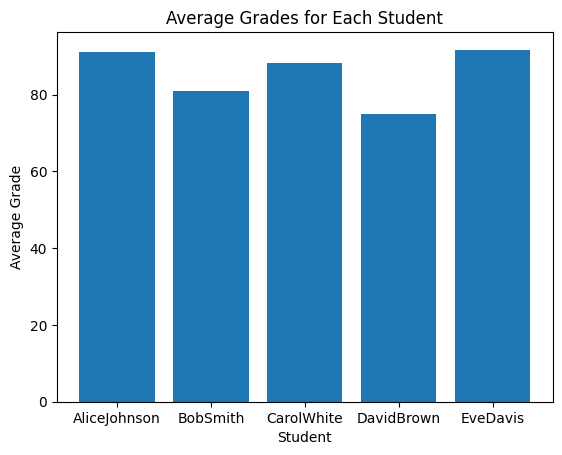

In [29]:
avg_grades_per_student = df_combined.groupby(['first_name', 'last_name'])['grade'].mean().reset_index()
plt.bar(avg_grades_per_student['first_name'] + '' + avg_grades_per_student['last_name'], avg_grades_per_student['grade'])
plt.xlabel('Student')
plt.ylabel('Average Grade')
plt.title('Average Grades for Each Student')
plt.show()

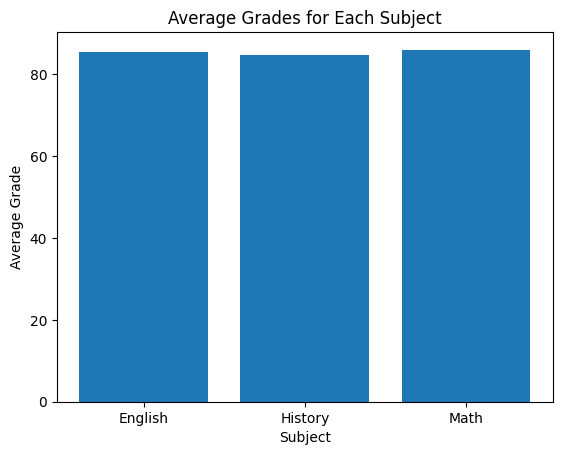

In [30]:
avg_grades_per_subject = df_combined.groupby('subject')['grade'].mean().reset_index()
plt.bar(avg_grades_per_subject['subject'], avg_grades_per_subject['grade'])
plt.xlabel('Subject')
plt.ylabel('Average Grade')
plt.title('Average Grades for Each Subject')
plt.show()

In [33]:
cursor.execute('''
WITH max_grades AS (
  SELECT subject, MAX(grade) AS max_grade
  FROM grades
  GROUP BY subject
)
SELECT s.first_name, s.last_name, g.subject, g.grade
FROM max_grades mg
JOIN grades g ON mg.subject = g.subject AND mg.max_grade = g.grade
JOIN students s ON g.student_id = s.student_id
''')

results = cursor.fetchall()

for x in results:
  print(x)

('Alice', 'Johnson', 'Math', 95)
('Alice', 'Johnson', 'History', 90)
('Eve', 'Davis', 'English', 94)


In [36]:
df_max_grades = pd.read_sql_query('''WITH max_grades AS (
  SELECT subject, MAX(grade) AS max_grade
  FROM grades
  GROUP BY subject
)
SELECT s.first_name, s.last_name, g.subject, g.grade
FROM max_grades mg
JOIN grades g ON mg.subject = g.subject AND mg.max_grade = g.grade
JOIN students s ON g.student_id = s.student_id
'''
    , connection)

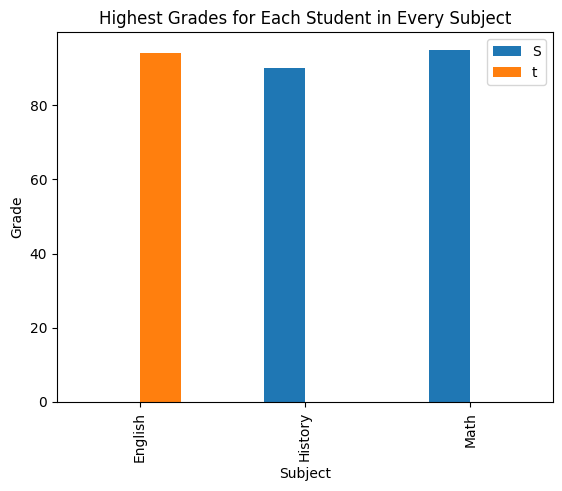

In [37]:
df_pivot = df_max_grades.pivot(index = 'subject', columns = ['first_name', 'last_name'], values = 'grade')
df_pivot.plot(kind = 'bar')
plt.xlabel('Subject')
plt.ylabel('Grade')
plt.legend('Student Name')
plt.title('Highest Grades for Each Student in Every Subject')
plt.show()

In [38]:
connection.close()